In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [93]:
orders_df = pd.read_csv("data/orders.csv")
payments_df = pd.read_csv("data/payments.csv")
plan_df = pd.read_csv("data/plan.csv")

### Шаг 1. Приведение данных и первичный анализ

Возьмем объект дата+время, распарсим его и возьмем только дату, для корректной группировки. Будем считать фактом просрочки платежа по дате - факт наступления следующего дня после `plan_date`.
Имея это в виду, *рассчитаем суммарный платеж за день для каждого заказа*:

In [94]:
payments_df["paid_at_date"] = pd.to_datetime(payments_df["paid_at"], format="%Y-%m-%d %H:%M:%S.%f").dt.date
payments_df = payments_df.groupby(["order_id", "paid_at_date"])["paid_sum"].sum().reset_index()
payments_df.head(3)

,order_id,paid_at_date,paid_sum
0,400001732,2022-06-02,5600.0
1,400001732,2022-06-16,3850.0
2,400001732,2022-07-15,2720.0


Объединим таблицы `plan_df` и `payments_df` по ключу `order_id` c сортировкой вдоль оси дат оплаты и приведением типов дат.

In [95]:
planNpayments = plan_df\
                    .merge(payments_df, on="order_id", sort="paid_at_date", how="right")\
                    .apply(lambda column: pd.to_datetime(column) 
                                if "_at" in column.name 
                                else column)

# Отбросим повторы значений по присоединенным payment-столбцам
planNpayments = planNpayments[planNpayments["plan_at"].dt.month == planNpayments["paid_at_date"].dt.month]

Разобьем кумулятивную сумму столбца `plan_sum_total` при помощи метода `.diff()` и заполним пропущенные значения, значениями первых сумм платежей, так, чтобы вычислять <u>разность между необходимой суммой платежа и платежом по факту</u>.

In [96]:
planNpayments["plan_sum"] = planNpayments\
                        .groupby("order_id")["plan_sum_total"]\
                        .diff()\
                        .fillna(planNpayments["plan_sum_total"])

Вычислим <u>разность</u>, описанную на предыдущем шаге, и *посчитаем кумулятивный остаток*. Таким образом,
- положительные значения в столбце `result` отвечают досрочному покрытию требуемой суммы;
- отрицательные значения в столбце `result` отвечают просрочке по платежу;
- равные 0 - строки, свидетельствующие о своевременном внесении платежа требуемой суммы.

In [97]:
planNpayments["pp_sum_diff"] = planNpayments["paid_sum"] - planNpayments["plan_sum"]
planNpayments["result"] = planNpayments.groupby("order_id")["pp_sum_diff"].cumsum()

In [98]:
total = planNpayments.shape[0]
debts = (planNpayments.result < 0).sum()
missed = ((planNpayments.result < 0) & (planNpayments.plan_at < planNpayments.paid_at_date)).sum()

print(
    f"""
    Подведем промежуточный итог, считая все транзакции за день по данному заказу одним платежом:\n
    По всем заказам произведено суммарно {total} платежей. 
    Из них долгов на конец расчетных периодов: {debts} в т.ч. просроченных платежей: {missed}
    """
)


    Подведем промежуточный итог, считая все транзакции за день по данному заказу одним платежом:

    По всем заказам произведено суммарно 225543 платежей. 
    Из них долгов на конец расчетных периодов: 18861 в т.ч. просроченных платежей: 1342
    


In [99]:
pieplot_data_dict = {
    "Выполненных обязательств": total - debts,
    "Невыполненных обязательств": debts - missed,
    "Просроченных платежей": missed
}
pieplot_data = pd.DataFrame(
    data=pieplot_data_dict,
    columns=pieplot_data_dict.keys(),
    index=[0]
)

Проиллюстрируем подведенный промежуточный итог на круговой диаграмме.

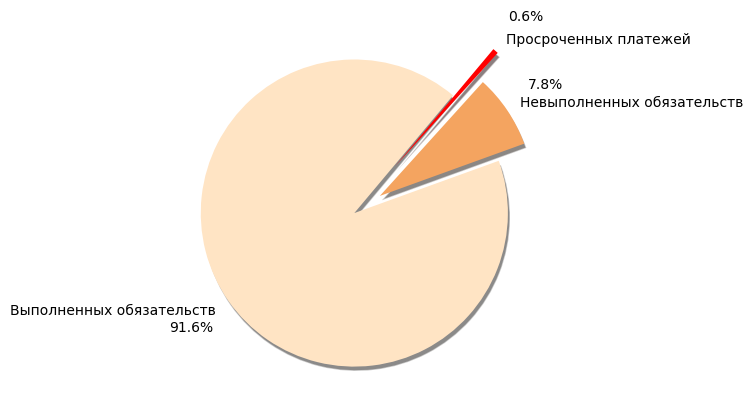

In [100]:
fig, ax = plt.subplots()
explode = [0, 0.2, 0.4]
colors = ["Bisque", "SandyBrown", "Red"]
shadow = {
    'ox': 0.01, 
    'edgecolor': 'white', 
    'shade': 0.9
}

labels = pieplot_data_dict.keys()
ax.pie(pieplot_data.iloc[0,:], 
       explode=explode, 
       labels=labels, 
       autopct='%1.1f%%',
       shadow=shadow,
       startangle=50,
       pctdistance=1.3,
       colors=colors
      )
plt.tight_layout()
plt.show()

### Шаг 2. Анализ динамики невыполненных обязательств

Под **невыполненными обязательствами** на этом шаге будем подразумевать **сумму невыполненых обязательств и просроченных платежей**, дифференцированных друг от друга на шаге 1

Построим график динамики количества всех выполненных и невыполненных обязательств в одних координатах. Для чего выделим соответствующих два датасета

In [101]:
import seaborn as sns

In [102]:
ffilled_oblgtns = planNpayments[planNpayments.result >= 0].groupby("paid_at_date")["result"].count().reset_index()
unffilled_oblgtns = planNpayments[planNpayments.result < 0].groupby("paid_at_date")["result"].count().reset_index()
ffilled_oblgtns['rolling'] = ffilled_oblgtns['result'].rolling(window=7).mean()
unffilled_oblgtns['rolling'] = unffilled_oblgtns['result'].rolling(window=7).mean()

In [103]:
obligations = ffilled_oblgtns.merge(
    unffilled_oblgtns, 
    on="paid_at_date",  
    suffixes=("_intime", "_late")
)

obligations["late_percent"] = (
    obligations["rolling_late"] / (
        obligations["rolling_intime"] + obligations["rolling_late"]
    ) * 100
).round(1)

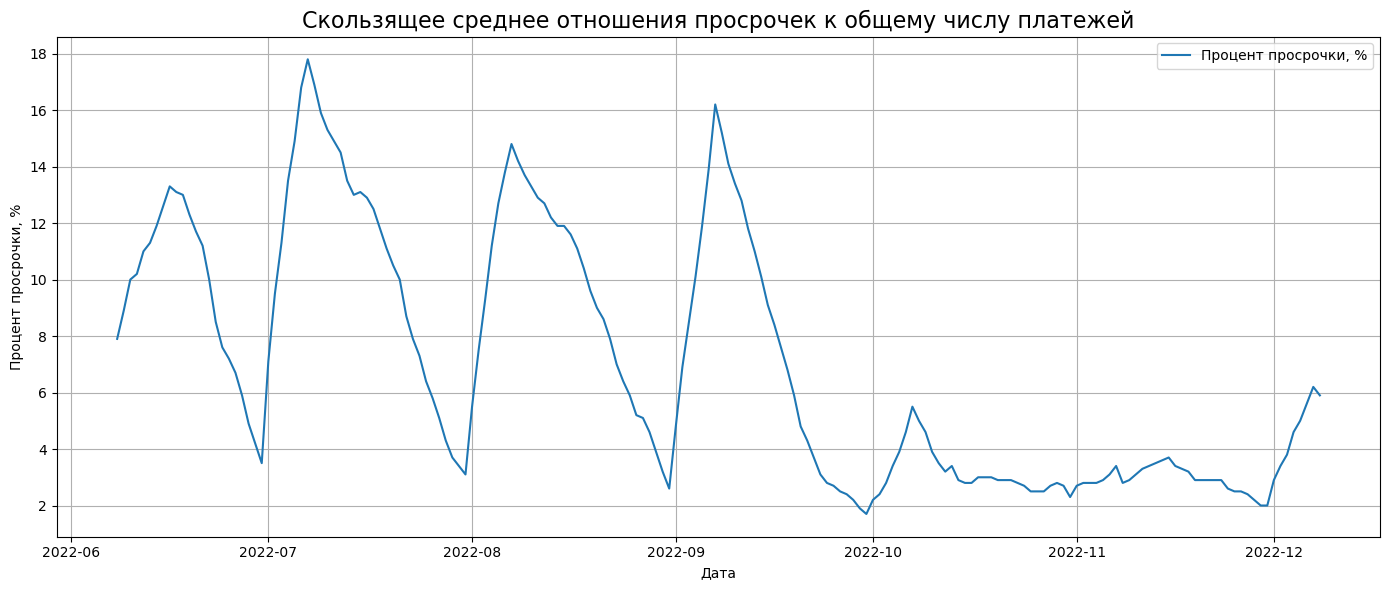

In [104]:
fig, ax = plt.subplots(figsize=(14, 6))
ylabel = "Процент просрочки, %"
sns.lineplot(x='paid_at_date', y='late_percent', data=obligations, label=ylabel, ax=ax)

plt.title("Скользящее среднее отношения просрочек к общему числу платежей", fontsize=16)
plt.xlabel("Дата")
plt.ylabel(ylabel)
plt.grid(True)
plt.tight_layout()
plt.show()

**ВЫВОД:** Полученная динамика временного ряда, отражающего процентное отношение количества просроченных платежей к суммарному количеству всех платежей, о тенденции к уменьшению просрочек по платежам к концу календарного года.
Пиковые значения (наибольшее количество просрочек), в основном, приходятся на начала расчетных периодов (месяцев) и, предположительно, могут быть обусловлены более поздними заработными платами, их просрочками и т.д.